# Introdução

*    Avaliar o desempenho dos modelos de classificação,
*    Diagnosticar alguns problemas comuns de algoritmos de aprendizado de máquina,
*    E avaliar modelos preditivos usando diferentes métricas de desempenho.

# Simplificando fluxos de trabalho com a classe ```pipelines``` do scikit-learn

Com pipelines nós vamos:

*   Organizar nosso código,
*   Facilitar a leitura,
*   Agilizar transformações de dados,
*   Facilitar o envio para produção.



## Carregando o conjunto de dados Breast Cancer Wisconsin

Fonte: https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data

In [ ]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header = None)

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df.shape

(569, 32)

In [ ]:
from sklearn.preprocessing import LabelEncoder

In [ ]:
X = df.loc[:, 2:].values
y = df.loc[:, 1].values

le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
le.classes_

array(['B', 'M'], dtype=object)

In [ ]:
le.transform(['M', 'B'])

array([1, 0])

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=1)

## Combinando transformadores e estimadores em um pipeline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

pipe_lr = make_pipeline(StandardScaler(),
              PCA(n_components=2),
              LogisticRegression(random_state=1, solver='lbfgs'))

pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=2)),
                ('logisticregression', LogisticRegression(random_state=1))])

In [ ]:
y_pred = pipe_lr.predict(X_test)
print('Acurácia: %.3f' % pipe_lr.score(X_test, y_test))

Acurácia: 0.956


<img src='https://drive.google.com/uc?export=view&id=1ez7HekZtcn0g9eLv82Dmwy8w9h0bPj1B' width="600">

# Usando validação cruzada k-fold para avaliar o desempenho do modelo

## O método holdout

<img src='https://drive.google.com/uc?export=view&id=1tzuUc6tlv-FqAR5adPjvDsMXXKDBGdOC' width="600">

In [ ]:
import numpy as np

X_train_ho, X_valid, y_train_ho, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

pipe_lr.fit(X_train_ho, y_train_ho)
score = pipe_lr.score(X_valid, y_valid)

print('Class dist.: %s, Acc: %.3f' % (np.bincount(y_train), score))

Class dist.: [285 170], Acc: 0.956


## O método k-fold

**Obs.:** Na figura a seguir, onde está escrito "Test fold", leia-se "Validation fold".

<img src='https://drive.google.com/uc?export=view&id=1Y6EbJNRNWBMXEg3eREQ6Mr_bgpHlo_5v' width="600">

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []

for k, (train, valid) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[valid], y_train[valid])

    scores.append(score)

    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1, np.bincount(y_train[train]), score))

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [ ]:
print('Mean acc.: %.3f' % np.mean(scores))

Mean acc.: 0.950


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=pipe_lr,
                          X=X_train,
                          y=y_train,
                          cv=10)

print('CV acc. scores: %s' % scores)

CV acc. scores: [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]


# Algoritmos de depuração com curvas de aprendizagem

<img src='https://drive.google.com/uc?export=view&id=1k81YmzUMgHHHLIlHxKPxAiwMysFsyz7u' width="600">

<img src='https://drive.google.com/uc?export=view&id=1RC8m1O5tGrp2XnI0RSOzIbgLDRvqW3pO' width="600">

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve


pipe_lr = make_pipeline(StandardScaler(),
                        LogisticRegression(penalty='l2', random_state=1,
                                           solver='lbfgs', max_iter=10000))

train_sizes, train_scores, test_scores =\
                learning_curve(estimator=pipe_lr,
                               X=X_train,
                               y=y_train,
                               train_sizes=np.linspace(0.1, 1.0, 10),
                               cv=10,
                               n_jobs=1)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

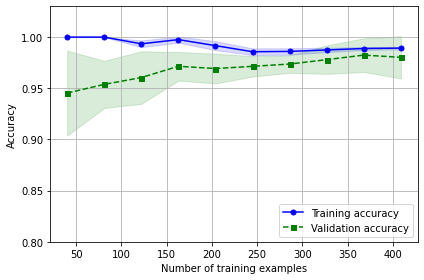

In [ ]:
plt.plot(train_sizes, train_mean,
         color='blue', marker='o',
         markersize=5, label='Training accuracy')

plt.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

plt.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='s', markersize=5,
         label='Validation accuracy')

plt.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

plt.grid()
plt.xlabel('Number of training examples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.03])
plt.tight_layout()
plt.show()

# Ajustando modelos de aprendizado de máquina por meio de pesquisa em grade

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),
                         SVC(random_state=1))

param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]

param_grid = [{'svc__C': param_range, 
               'svc__kernel': ['linear']},
              {'svc__C': param_range, 
               'svc__gamma': param_range, 
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}


# Algumas observações sobre o treinamento e ajuste de hiperparâmetros:

Qualquer processo que envolva probabilidade, poderá gerar resultados distintos a cada experimento. Se tivermos uma superfície comportada de busca e/ou se o método utilizado for robusto, existe uma **maior probabilidade** de encontrarmos o que chamamos de mínimo/máximo global. Observem que maior probabilidade não indica garantia.

O processo de ajuste do classificador (arquitetura e hiperparâmetros) é realizado diversas vezes e, neste processo, não podemos utilizar o conjunto de teste para verificar se estamos no caminho certo. Então, os exemplos acima utilizam o conjunto de validação para obter essa análise em tempo de aprendizado.

Finalizado o processo de ajuste da arquitetura e dos hiperparâmetros, faz-se uso do conjunto de teste para definir o desempenho real e final do método escolhido.

Detalhe: caso o objetivo seja comparar diversos classificadoress distintos (ex.: Árvore de Decisão x SVM x MLP), cada classificador deverá ser treinado, ajustado e testado. E, para este processo, o resultado a ser comparado serão as métricas aplicadas sobre o conjunto de teste, que veremos a seguir.

In [ ]:
clf = gs.best_estimator_

print('Test accuracy: %.3f' % clf.score(X_test, y_test))

Test accuracy: 0.974


# Olhando para diferentes métricas de avaliação de desempenho

<img src='https://drive.google.com/uc?export=view&id=1nn6gbk99-uoup5QtR5pu80x5mlBVxLgT' width="500">

In [ ]:
from sklearn.metrics import confusion_matrix

pipe_svc.fit(X_train, y_train)
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[71  1]
 [ 2 40]]


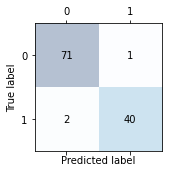

In [ ]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()

## Otimizando a precisão e a revocação (recall) de um modelo de classificação

Erro (ERR):

$$ERR = \frac{FP+FN}{FP+FN+TP+TN}$$

Acurácia (ACC):

$$ACC = \frac{TP+TN}{FP+FN+TP+TN} = 1-ERR$$

Precisão (PRE):

$$PRE = \frac{TP}{TP+FP}$$

Sensibilidade / Revocação (REC - Recall):

$$REC = \frac{TP}{P} = \frac{TP}{FN+TP}$$

https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall#precision-and-recall:-a-tug-of-war

Especificidade (SPE):

$$SPE = \frac{TN}{N} = \frac{TN}{FP+TN}$$

Eficiência (EFF):

$$EFF = \frac{REC+SPE}{2}$$

F1 Score (F1):

$$F1 = 2 \frac{PRE \times REC}{PRE+REC}$$

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


In [ ]:
from sklearn.metrics import make_scorer

scorer = make_scorer(f1_score, pos_label=0)

c_gamma_range = [0.01, 0.1, 1.0, 10.0]

param_grid = [{'svc__C': c_gamma_range,
               'svc__kernel': ['linear']},
              {'svc__C': c_gamma_range,
               'svc__gamma': c_gamma_range,
               'svc__kernel': ['rbf']}]

gs = GridSearchCV(estimator=pipe_svc,
                  param_grid=param_grid,
                  scoring=scorer,
                  cv=10,
                  n_jobs=-1)
gs = gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.9861994953378878
{'svc__C': 10.0, 'svc__gamma': 0.01, 'svc__kernel': 'rbf'}


## Plottando uma curva Característica de Operação do Receptor (ROC)

<img src='https://drive.google.com/uc?export=view&id=1SYkc048ig80rIiOlrZnRTDASmG4pAGpY' width="600">

In [ ]:
from sklearn.metrics import roc_curve, auc
from distutils.version import LooseVersion as Version
from scipy import __version__ as scipy_version


if scipy_version >= Version('1.4.1'):
    from numpy import interp
else:
    from scipy import interp


pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=2),
                        LogisticRegression(penalty='l2', 
                                           random_state=1,
                                           solver='lbfgs',
                                           C=100.0))

X_train2 = X_train[:, [4, 14]]
    

cv = list(StratifiedKFold(n_splits=3).split(X_train, y_train))

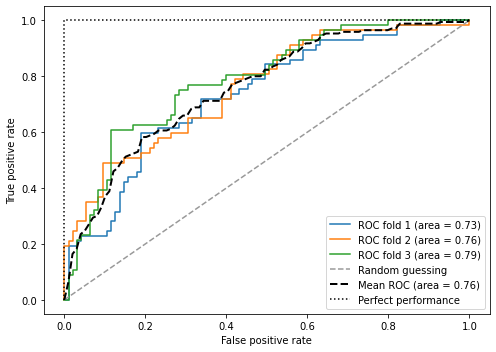

In [ ]:
fig = plt.figure(figsize=(7, 5))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],
                         y_train[train]).predict_proba(X_train2[test])

    fpr, tpr, thresholds = roc_curve(y_train[test],
                                     probas[:, 1],
                                     pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='Random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()